In [2]:
import torch
import numpy as np
import os
from matplotlib import cm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
from plotting import ScalogramPlotter
%matplotlib inline
%matplotlib notebook

In [10]:
test_file_roi = "/pasteur/appa/scratch/cbangu/coefficients/covert_producing_roi_beamforming/BCOM_07_2_a_112_coefficients.npy"
roi_array = np.load(test_file_roi)

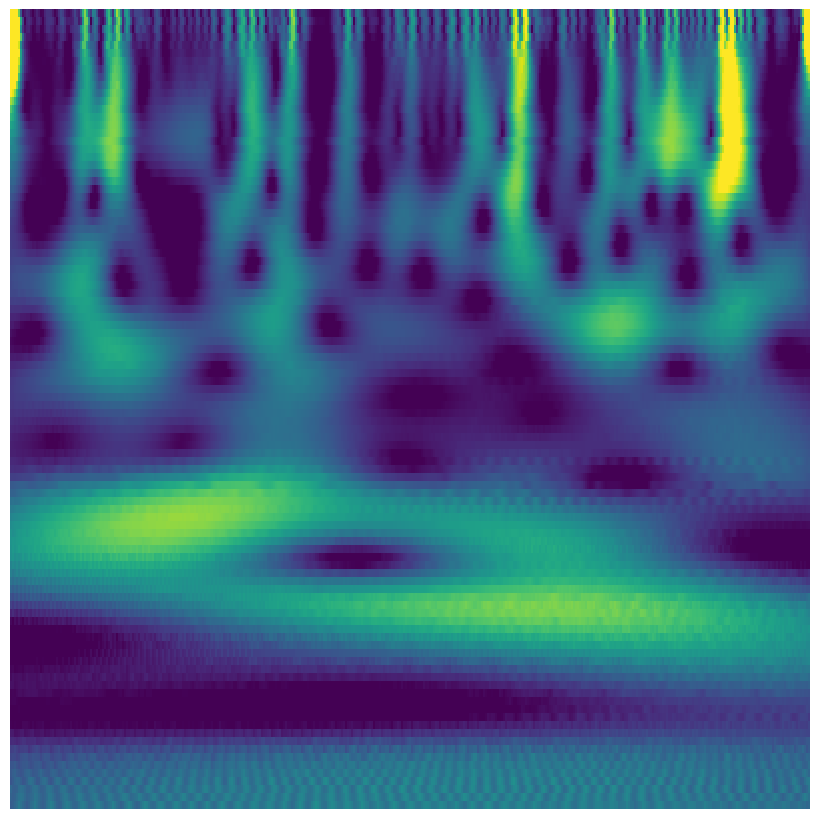

In [11]:
roi_plotter = ScalogramPlotter(dimensions=(1, 1), 
                               cmap='viridis',
                               index_list=[0],
                               data_dir="/pasteur/appa/homes/cbangu/MEG-Decoding", 
                               save_dir="/pasteur/appa/homes/cbangu/MEG-Decoding", 
                               resolution=300, 
                               vmin=-1.2358, 
                               vmax=2.5938)

roi_fig = roi_plotter.plot_roi(roi_array[0])
roi_fig


In [12]:
plotter = ScalogramPlotter(
    dimensions=(16, 16), 
    cmap='viridis', 
    data_dir="/pasteur/appa/homes/cbangu/MEG-Decoding", 
    save_dir="/pasteur/appa/homes/cbangu/MEG-Decoding", 
    resolution=300,
    vmin=-1.6452,
    vmax=2.9506,
)

In [13]:
test_file = "/pasteur/appa/scratch/cbangu/coefficients/covert_producing/BCOM_07_2_a_112_coefficients.npy"
array = np.load(test_file)

In [14]:
for epoch, sensors in enumerate(array):
    print(epoch)
    print(sensors.shape)

0
(247, 100, 401)
1
(247, 100, 401)
2
(247, 100, 401)
3
(247, 100, 401)
4
(247, 100, 401)
5
(247, 100, 401)
6
(247, 100, 401)
7
(247, 100, 401)
8
(247, 100, 401)
9
(247, 100, 401)
10
(247, 100, 401)
11
(247, 100, 401)
12
(247, 100, 401)
13
(247, 100, 401)
14
(247, 100, 401)
15
(247, 100, 401)
16
(247, 100, 401)


In [15]:
array.shape

(17, 247, 100, 401)

In [16]:
fig = plotter.plot_many(array[0])

plotting 0s for channel index: 247
plotting 0s for channel index: 248
plotting 0s for channel index: 249
plotting 0s for channel index: 250
plotting 0s for channel index: 251
plotting 0s for channel index: 252
plotting 0s for channel index: 253
plotting 0s for channel index: 254
plotting 0s for channel index: 255


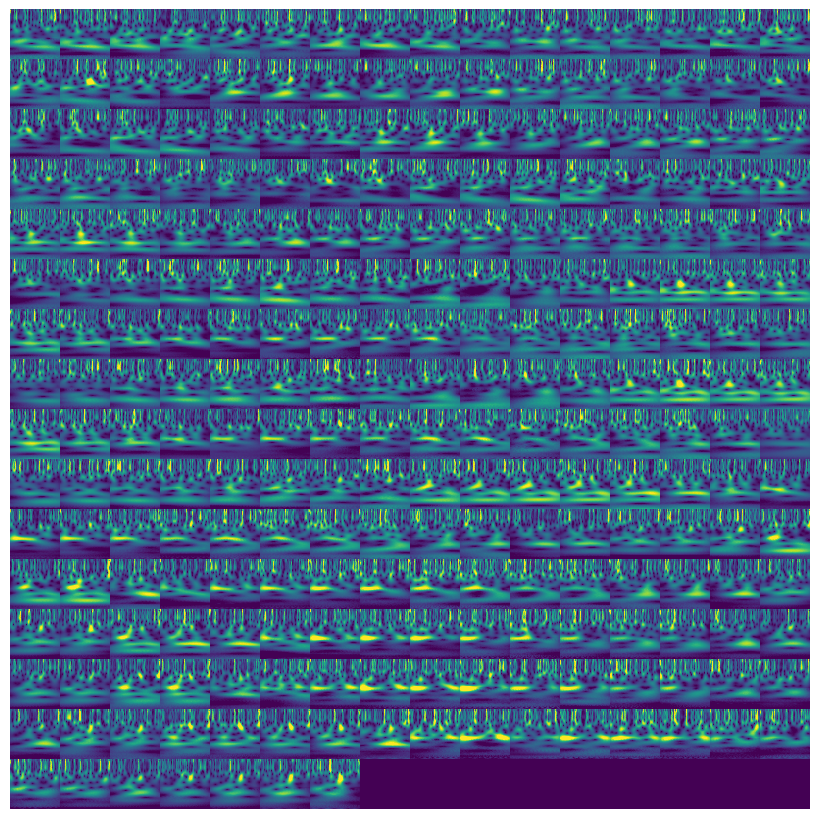

In [17]:
fig

In [18]:
smaller_plotter = ScalogramPlotter(
    dimensions=(3, 3), 
    cmap='viridis', 
    data_dir="/pasteur/appa/homes/cbangu/MEG-Decoding", 
    save_dir="/pasteur/appa/homes/cbangu/MEG-Decoding", 
    index_list=[208, 209, 244, 243, 225, 171, 156, 195, 245],
    resolution=300,
    vmin=-1.6452,
    vmax=2.9506,
)

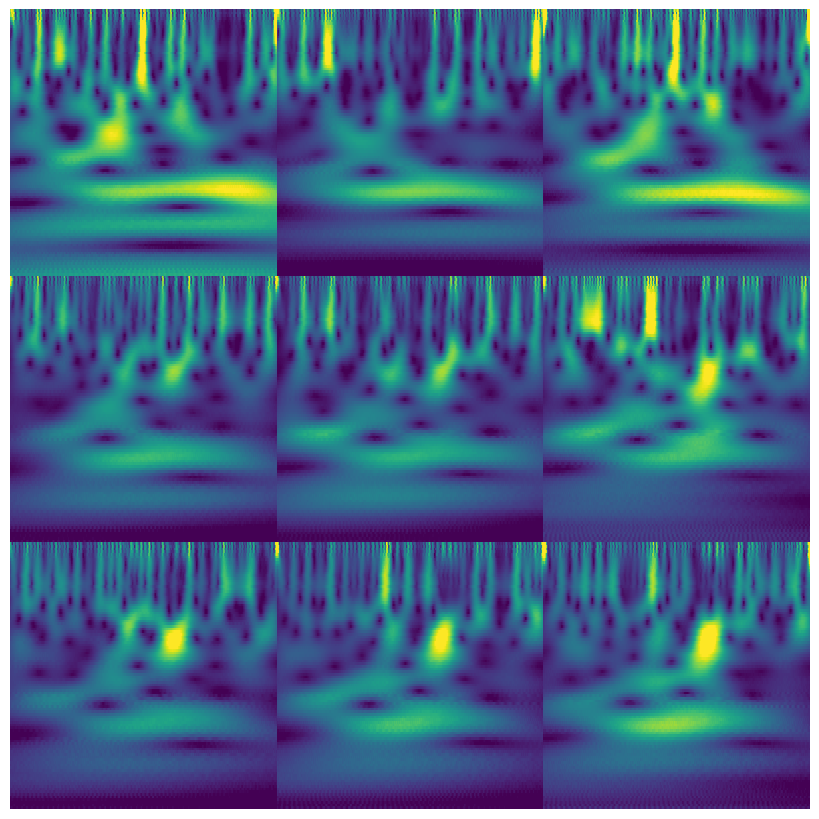

In [19]:
smaller_plotter.plot_many(array[0])

In [20]:
p_array = []
for epoch in array:
    for sensor in epoch:
        p_array.append(np.percentile(sensor, 99))
    break
np.array(p_array).mean()

np.float64(2.370534042686482)

In [38]:
test_file_2 = "/pasteur/appa/scratch/cbangu/coefficients/covert_reading/BCOM_13_2_ti_66_coefficients.npy"
array_2 = np.load(test_file_2, mmap_mode="r")

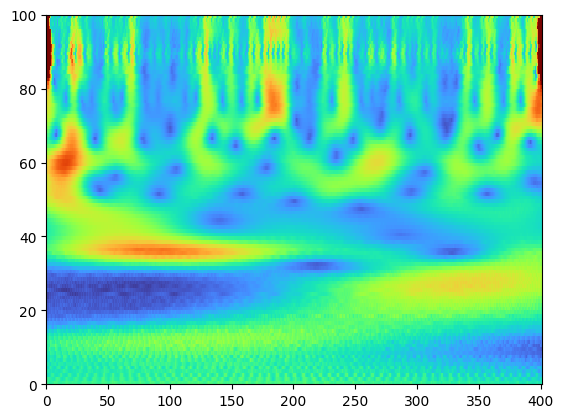

In [39]:
plt.pcolormesh(array_2[0][0], cmap='turbo', vmin=-2.47, vmax=4.38)

In [21]:
plt.hist(array_2[4][np.random.choice(256)])

NameError: name 'array_2' is not defined

In [41]:
def zscore_to_rgb(z, vmin, vmax):
    z_clipped = np.clip((z-vmin)/(vmax - vmin), 0, 1) #normalize between 0 and 1
    rgb = cm.turbo(z_clipped)[..., :3] # shape: (H, W, 3)
    rgb = np.transpose(rgb, (2, 0, 1)) # (3, H, W)
    return rgb.astype(np.float32)

In [42]:
rgb_tensor = zscore_to_rgb(array_2[4][np.random.choice(256)], vmin=-5, vmax=5)

In [43]:
from torchvision.transforms import Resize

In [44]:
resize = Resize((224, 224))
rgb_resized = resize(torch.tensor(rgb_tensor))

In [88]:
def zscore_to_rgb_tensor(z, vmin, vmax):
    """This function takes in the zscored coefficeints, and turns them into an RGB tensor via the turbo colormap"""
    z_clipped = np.clip((z - vmin )/(vmax - vmin), 0, 1)
    rgb = cm.turbo(z_clipped)[..., :3]
    rgb = np.transpose(rgb, (2, 0, 1))
    return torch.from_numpy(rgb).float()

def auto_layout_square(n):
    """This helper function computes the dimensions of the scalogram collage"""
    return math.ceil(math.sqrt(n)), math.ceil(math.sqrt(n))

def stitch_scalograms(rgb_list, layout):
    """This function stitched the scalograms together for the collage"""
    rows, cols = layout
    H, W = rgb_list[0].shape[1:] # get the right dimension
    total_tiles = rows * cols
    n_patches = len(rgb_list)
    n_missing = total_tiles - n_patches
    
    blank = torch.zeros((3, H, W), dtype=rgb_list[0].dtype) # make the padding arrays
    
    # it gets plotted from front to back so I need to the empty ones first
    full_list = rgb_list[:]
    if n_missing > 0:
        full_list += [blank] * n_missing
    
    stitched_rows = [ # stitches all of the rows together
        torch.cat(full_list[r * cols: (r + 1) * cols], dim=2)
        for r in range(rows)
    ] 
    
    stitched_rows = stitched_rows[::-1]
    return torch.cat(stitched_rows, dim=1) # concatenate on the height

def generate_scalogram(coefficients, sensor_indices, vmin, vmax, output_size=(224, 224)):
    rgb_list = []
    for idx in sensor_indices:
        z = coefficients[idx] # get the coefficients
        rgb = zscore_to_rgb_tensor(z, vmin=vmin, vmax=vmax) #transform them into rgb_tensors
        rgb_list.append(rgb)

    layout=auto_layout_square(len(sensor_indices)) # get layout dimensions
    collage = stitch_scalograms(rgb_list, layout=layout) # stitch em
    collage_resized = F.interpolate(collage.unsqueeze(0), size=output_size, mode='bicubic', align_corners=False).squeeze(0) #resize to AlexNet specs

    # return collage
    return collage_resized


In [93]:
list(range(246))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


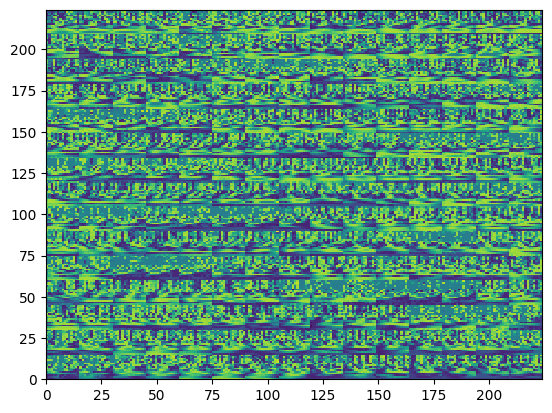

In [103]:
plt.pcolormesh(generate_scalogram(array[6], list(range(225)), vmin=-3, vmax=3)[0])

### ok now to find vmin and vmax for all of the different data types

we'll just take it as the mean of the 99th percentile for the zscores in each category

In [104]:
covert_producing_sensors = "/pasteur/appa/scratch/cbangu/coefficients/covert_producing"
covert_reading_sensors = "/pasteur/appa/scratch/cbangu/coefficients/covert_reading"
overt_producing_sensors = "/pasteur/appa/scratch/cbangu/coefficients/overt_producing"

In [ ]:
p_min, p_max = [], []
all_files = len(os.listdir(covert_producing_sensors))
counter = 0
for file in os.listdir(covert_producing_sensors):
    np_file = os.path.join(covert_producing_sensors, file)
    file = np.load(np_file, mmap_mode="r")
    for epoch in file:
        for sensor in epoch:
            # get the outliers
            p_max.append(np.percentile(sensor, 99))
            p_min.append(np.percentile(sensor, 1))
    counter += 1
    if counter % 5 == 0:
        print(f"{counter} files done, {all_files - counter} left")
    

mean_max = np.array(p_max).mean()
mean_min = np.array(p_min).mean()

print(f"mean 99th percentile z_score: {mean_max}")
print(f"mean 1th percentile z_score: {mean_min}")

5 files done, 1129 left
10 files done, 1124 left
15 files done, 1119 left
20 files done, 1114 left
25 files done, 1109 left
30 files done, 1104 left
35 files done, 1099 left
40 files done, 1094 left
45 files done, 1089 left
50 files done, 1084 left
55 files done, 1079 left
60 files done, 1074 left
65 files done, 1069 left
70 files done, 1064 left
75 files done, 1059 left
80 files done, 1054 left
85 files done, 1049 left
90 files done, 1044 left
95 files done, 1039 left
100 files done, 1034 left
105 files done, 1029 left
110 files done, 1024 left
115 files done, 1019 left
120 files done, 1014 left
125 files done, 1009 left
130 files done, 1004 left
135 files done, 999 left
140 files done, 994 left
145 files done, 989 left
150 files done, 984 left
155 files done, 979 left
160 files done, 974 left
165 files done, 969 left
170 files done, 964 left
175 files done, 959 left
180 files done, 954 left
185 files done, 949 left
190 files done, 944 left
195 files done, 939 left
200 files done, 934